<a href="https://colab.research.google.com/github/knotseaborg/Machine-Learning-Projects/blob/master/Product_classification_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of Products into categories using Pre-trained BERT

In [ ]:
#Additional libraries
!pip install transformers
!unzip "/content/drive/My Drive/Dataset/Flipkart products/archive.zip" -d "/content"

### Importing Libraries

In [4]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import transformers
from transformers import AutoModel, BertTokenizerFast, AdamW

import warnings
warnings.filterwarnings('ignore')

# specify GPU
device = torch.device("cuda")

### Reading data

In [5]:
#Reading data
file = "/content/flipkart_com-ecommerce_sample.csv"
data = pd.read_csv(file)

In [6]:
target_data = data[["product_name", "product_category_tree", "description"]]
category_counts = target_data["product_category_tree"].apply(lambda x: x.split(">>")[0][2:]).value_counts()
category_list = category_counts[category_counts > 9].index

In [7]:
def get_main_category(category_tree, category_list):
    for category in category_list:
        if category in category_tree:
            return category
    return "NONE"

target_data["main_category"] = target_data["product_category_tree"].apply(lambda x: get_main_category(x, category_list))

In [8]:
target_data.head()

,product_name,product_category_tree,description,main_category
0,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",Key Features of Alisha Solid Women's Cycling S...,Clothing
1,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",FabHomeDecor Fabric Double Sofa Bed (Finish Co...,Furniture
2,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",Key Features of AW Bellies Sandals Wedges Heel...,Footwear
3,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",Key Features of Alisha Solid Women's Cycling S...,Clothing
4,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",Specifications of Sicons All Purpose Arnica Do...,Pet Supplies


### Data Exploration

In [9]:
target_data.main_category.value_counts()

Clothing                              6198
Jewellery                             3535
Footwear                              1227
Mobiles & Accessories                 1099
Automotive                            1012
Home Decor & Festive Needs             928
Beauty and Personal Care               707
Home Furnishing                        702
Kitchen & Dining                       650
Computers                              578
Watches                                530
Baby Care                              483
Tools & Hardware                       391
NONE                                   335
Toys & School Supplies                 330
Pens & Stationery                      313
Bags, Wallets & Belts                  265
Furniture                              177
Sports & Fitness                       166
Cameras & Accessories                   82
Home Improvement                        81
Health & Personal Care Appliances       43
Gaming                                  35
Sunglasses 

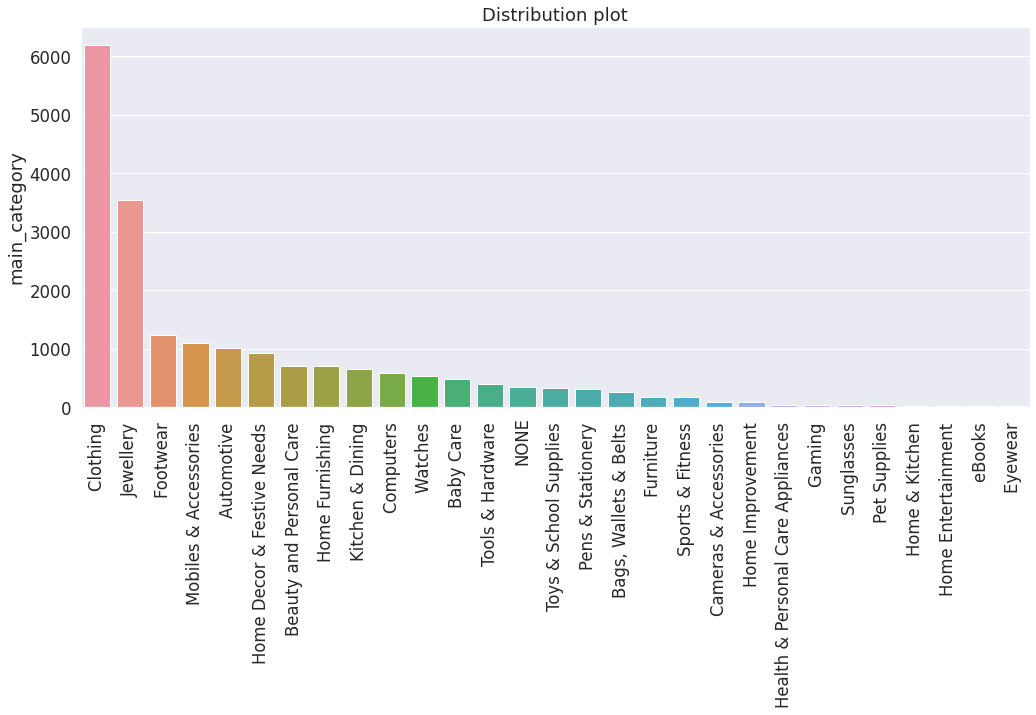

In [10]:
sns.set(font_scale=1.5)
frequency = target_data.main_category.value_counts()
fig, ax = plt.subplots(figsize=(17,7))
ax.grid(True)
chart0 = sns.barplot(frequency.index, frequency, ax = ax)
chart0.set_xticklabels(frequency.index,rotation=90)
chart0.set_title("Distribution plot")
plt.show()

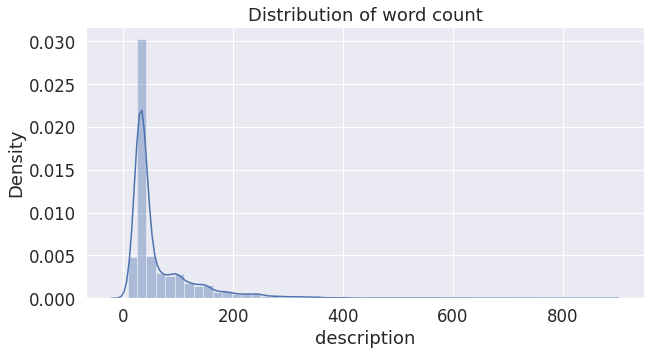

In [61]:
fig, ax = plt.subplots(figsize=(10,5))
chart = sns.distplot(target_data.dropna(inplace=False, how="any").description.apply(lambda x: len(x.split())), bins = 50, ax = ax)
chart.set_title("Distribution of word count")
plt.show()

### Preprocessing and data cleaning

In [12]:
#Cleaning data, removing rows with missing data
target_data.dropna(inplace=True, how="any")
target_data = target_data[target_data["main_category"] != "NONE"]

In [13]:
#Label encoding of the categories
label_encoding = {}
for label, n in zip(category_list, range(28)):
    label_encoding[label] = n

#Adding encoded label to input
target_data["encoded_label"] = target_data["main_category"].apply(lambda x: label_encoding[x])

In [14]:
#Preparing data for neural network
input_data, label_data = target_data["description"], target_data["encoded_label"]

train_text, temp_text, train_labels, temp_labels = train_test_split(input_data, label_data, 
                                                                    random_state=2020, 
                                                                    test_size=0.3, 
                                                                    stratify=label_data)

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [15]:
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)
print("Class Weights:",class_weights)

Class Weights: [ 0.11331753  0.198695    0.5722601   0.63923463  0.69430993  0.75626374
  0.99307359  1.00116381  1.08037677  1.21375661  1.32499037  1.45435334
  1.79405631  2.12801484  2.2446184   2.65714286  3.96428571  4.23768473
  8.62406015  8.62406015 16.38571429 20.48214286 19.66285714 23.40816327
 28.91596639 37.81318681 44.68831169 70.2244898 ]


In [16]:
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize_batch(data_series, max_length):
    return tokenizer.batch_encode_plus(
        data_series.tolist(),
        max_length = max_length,
        pad_to_max_length=True,
        truncation=True
    ) 

tokens_train = tokenize_batch(train_text, 40)
tokens_val = tokenize_batch(val_text, 40)
tokens_test = tokenize_batch(test_text, 40)

In [17]:
## convert lists to tensors
def convert_to_tensor(tokenized_data):
    return (torch.tensor(tokenized_data['input_ids']), torch.tensor(tokenized_data['attention_mask']))

train_seq, train_mask = convert_to_tensor(tokens_train)
train_y = torch.tensor(train_labels.values)

val_seq, val_mask = convert_to_tensor(tokens_val)
val_y = torch.tensor(val_labels.values)

test_seq, test_mask = convert_to_tensor(tokens_test)
test_y = torch.tensor(test_labels.values)

In [18]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data) #sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data) #sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

### Creating Neural Network Model

In [19]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

In [20]:
# unfreeze all the parameters. No fine tuning, full on re-training!
for param in bert.parameters():
    param.requires_grad = True

In [21]:
class BERT_Arch(nn.Module):

    def __init__(self, bert, n_classes):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      self.dropout = nn.Dropout(0.1)
      self.relu =  nn.ReLU()
      self.fc1 = nn.Linear(768,512)
      self.fc2 = nn.Linear(512,n_classes)
      self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      # output layer
      x = self.fc2(x)
      # apply softmax activation
      x = self.softmax(x)

      return x

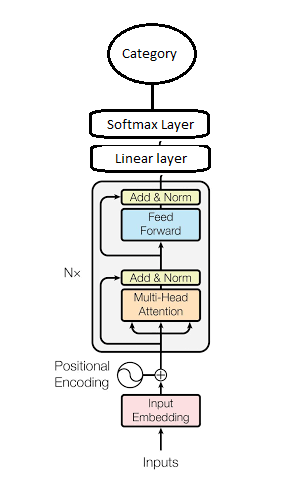

Reference: https://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf

In [22]:
"""
Initializing Model
"""

model = BERT_Arch(bert, 28)
# push the model to GPU
model = model.to(device)

### Training the Model

In [23]:
"""
Setting training parameters
"""

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-4) # learning rate
# define the loss function
weights= torch.tensor(class_weights, dtype=torch.float)
weights = weights.to(device)
cross_entropy  = nn.NLLLoss(weight=weights) 
# number of training epochs
epochs = 10

In [24]:
# function to train the model
def train():
  
  model.train()
  total_loss, total_accuracy = 0, 0
  total_preds=[] 
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch

    model.zero_grad() #reset gradient to zero       
    preds = model(sent_id, mask)
    loss = cross_entropy(preds, labels)
    total_loss = total_loss + loss.item() #adding to loss
    loss.backward() #backpropagate

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step() #update weights

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  # reshaping output from (no. of batches, size of batch, no. of classes) -> (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [25]:
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model prediction
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    431.
  Batch   100  of    431.
  Batch   150  of    431.
  Batch   200  of    431.
  Batch   250  of    431.
  Batch   300  of    431.
  Batch   350  of    431.
  Batch   400  of    431.

Evaluating...
  Batch    50  of     93.

Training Loss: 1.882
Validation Loss: 0.913

 Epoch 2 / 10
  Batch    50  of    431.
  Batch   100  of    431.
  Batch   150  of    431.
  Batch   200  of    431.
  Batch   250  of    431.
  Batch   300  of    431.
  Batch   350  of    431.
  Batch   400  of    431.

Evaluating...
  Batch    50  of     93.

Training Loss: 0.766
Validation Loss: 0.658

 Epoch 3 / 10
  Batch    50  of    431.
  Batch   100  of    431.
  Batch   150  of    431.
  Batch   200  of    431.
  Batch   250  of    431.
  Batch   300  of    431.
  Batch   350  of    431.
  Batch   400  of    431.

Evaluating...
  Batch    50  of     93.

Training Loss: 0.594
Validation Loss: 0.761

 Epoch 4 / 10
  Batch    50  of    431.
  Batch   100  of    431.
  Batc

### Loading best model

In [26]:
#load weights of best model
path = '/content/drive/My Drive/Dataset/Flipkart products/saved_weights.pt'
model.load_state_dict(torch.load(path))

# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

#Obtain classification report
pred_y = np.argmax(preds, axis = 1)

### Prediction Result on test dataset

In [27]:
def reverse_encode_labels(encoded_labels, label_encoding):
    labels = []
    for encoded_label in encoded_labels:
        for key in label_encoding:
            if label_encoding[key] == encoded_label:
                labels.append(key)
                break
    return labels

predicted_output = reverse_encode_labels(pred_y, label_encoding)
test_output = reverse_encode_labels(test_y, label_encoding)

In [28]:
print(classification_report(test_output, predicted_output))

                                    precision    recall  f1-score   support

                       Automotive        0.99      0.97      0.98       152
                        Baby Care        0.88      0.81      0.84        73
            Bags, Wallets & Belts        0.93      0.93      0.93        40
         Beauty and Personal Care        0.93      0.97      0.95       106
            Cameras & Accessories        1.00      0.92      0.96        12
                         Clothing        0.99      0.99      0.99       930
                        Computers        0.94      0.93      0.94        87
                          Eyewear        0.33      1.00      0.50         1
                         Footwear        1.00      0.98      0.99       184
                        Furniture        0.96      0.92      0.94        26
                           Gaming        0.00      0.00      0.00         5
Health & Personal Care Appliances        0.86      1.00      0.92         6
           

In [29]:
for text, pred_c, test_c in zip(test_text, predicted_output, test_output):
    if pred_c != test_c: 
      print("----------------")
      print("Description: \n", text[:100])
      print("Predicted Category: \n", pred_c)
      print("True Category: \n", test_c)
      print("----------------")

----------------
Description: 
 Key Features of NESTWELL HAND BLENDER EGG,LASSI,BUTTER,MILK,JUICE LIQUIDIZING 0 W Hand Blender 100% 
Predicted Category: 
 Kitchen & Dining 
True Category: 
 Home & Kitchen 
----------------
----------------
Description: 
 Flipkart.com: Buy Pinnakle Dual Compartment Sports Art Polypropylene Pencil Box only for Rs. 179 fro
Predicted Category: 
 Pens & Stationery 
True Category: 
 Toys & School Supplies 
----------------
----------------
Description: 
 Specifications of Woly Smooth Leather Shoe Cream (Brown) General Suitable for Leather Components Sil
Predicted Category: 
 Beauty and Personal Care 
True Category: 
 Footwear 
----------------
----------------
Description: 
 Key Features of NITGEN eNBioAccess T5-HID Time & Attendance, Access Control, Door Locks PowerOnEther
Predicted Category: 
 eBooks 
True Category: 
 Pens & Stationery 
----------------
----------------
Description: 
 Buy Marvel Cotton Bath Towel at Rs. 449 at Flipkart.com. Only Genuine Pr

### Save test results

In [30]:
#To save model in drive, if it's eally good.
#!cp "/content/saved_weights.pt" "/content/drive/My Drive/Dataset/Flipkart products/saved_weights.pt"

In [31]:
dataframe = pd.DataFrame()
for text, pred_c, test_c in zip(test_text, predicted_output, test_output):
    dataframe = dataframe.append({"description":text, "predicted_category": pred_c, "true category": test_c}, ignore_index=True)
dataframe.head()
dataframe.to_csv("sample_result.csv")

## Word level XGBoost Sample 

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
import xgboost

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(target_data['description'])

encoder = preprocessing.LabelEncoder()
encoder.fit(target_data['main_category'])

word_level_classifier = xgboost.XGBClassifier()
word_level_classifier.load_model('/content/drive/My Drive/Dataset/Flipkart products/xgboost_word_level_classifier.model')
word_level_classifier._le = preprocessing.LabelEncoder().fit(range(28))

def xgboost_classify(text):
    text = text.replace("\n", " ")
    x_tfidf =  tfidf_vect.transform(pd.Series([text]))

    predictions = word_level_classifier.predict(x_tfidf.tocsc())
    return encoder.inverse_transform(predictions)

xgboost_classify("Gold watch")

array(['Watches '], dtype=object)

## BERT Interactive Sample

In [33]:
def bert_classify(description):
    description = description.replace("\n", " ")
    tokens_sample = tokenize_batch(pd.Series([description]), 40)
    sample_seq, sample_mask = convert_to_tensor(tokens_sample)

    preds = model(sample_seq.to(device), sample_mask.to(device)).detach().cpu().numpy()
    encoded_label = np.argmax(preds, axis = 1)
    return reverse_encode_labels(encoded_label, label_encoding)

In [34]:
input_ = """Get Best Printed Cover for your phone, These Mobile Cover Printed through the UV Technology so it can be use for daily basis and these stylish and Designer Premium Back Cover Case from BuyFeb."""

bert_classify(input_)

['Mobiles & Accessories ']

## Dual output Sample

In [77]:
input_ = """"D\nSAMSUNG\n85 CHALLENGER ROAD, RIDGEFIELD PARK N.J.07660-2112, U.S.A.\nModel /MODELE NO / Modelo.: HG40NC670DF DIST BY SAMSUNG ELECTRONICS CANADA INC.\nType No.: HG40NC670\n55 Standish Court Mississauga, Ontario L5R 4B2 Canada\nUSA/CANADA : AC110-120V-50/60Hz 98W Typical power: 37W\nMEXICO: 110-127V c.a.- 50/60Hz 98W CAN ICES-3 (B) /NMB-3 (B)\nStandard Television Receiving Apparatus - Appareil de réception télévision adnaire, Canada BETST /NTMR-7\nMFD./FABRIQUE/MANUFACTURADO: APRIL 2014\nFCC ID:A3LHG40NC67X\nThis device complies with part 15 of the FCCRUES.\nC US\nOperation is subject to the following two conctions:\n(1)this device may not cause harmful interference\nand (2) this device must accept any interference received\nLISTED\nincluding interference that may cause unde sired operation.\nTelevision Receiver\nMADE IN TIANJIN CHINA(TSEC)\nEnergy Verified\n70FJ\nFABRIQUE AU TIANJIN CHINE(TSEC)\nN\nC\nNYCE\nNOM ET\nA\nModel Code : HG40NC670DFXZA\nVersion No: XXXX\nS/N : Serie No : ************Z\nCAUTION\nRISK OF ELECTRIC SHOCK\nDO NOT OPEN\nWARNING: TO PREVENT FIRE OR SHOCK HAZARD\nDO NOT EXPOSE THIS UNIT TO RAIN OR MOISTURE\nAL\n"""

print("XGBoost result: ", xgboost_classify(input_))
print("Bert result: ", bert_classify(input_))

XGBoost result:  ['Clothing ']
Bert result:  ['Tools & Hardware ']
